In [1]:
import pandas as pd
import math
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import time
import sys
from pixell import enmap, enplot, reproject, utils, curvedsky, wcsutils
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from tqdm import tqdm
import random
import time
import multiprocessing as mp
import numpy as np
import random
import time
import multiprocessing as mp
import numpy as np

---

---

# Read in data

#### Catalog

In [86]:
ard_not_adv = pd.read_csv('../data/ard_not_adv.csv', skiprows = 0)

In [102]:
ras_good = []
decs_good = []

In [125]:
ras_fake = ard_not_adv['amf_ra']+random.uniform(-1,1)
decs_fake = ard_not_adv['amf_dec']+random.uniform(-1,1)

for i in tqdm(range(len(ras_fake))):
    matches = ard_not_adv.loc[(ard_not_adv['amf_ra'].sub(ras_fake[i]).abs()<1) & (ard_not_adv['amf_dec'].sub(decs_fake[i]).abs()<1)]
    if len(matches)==0:  
        ras_good.append(ras_fake[i])
        decs_good.append(decs_fake[i])

100%|██████████| 21006/21006 [00:43<00:00, 478.51it/s]


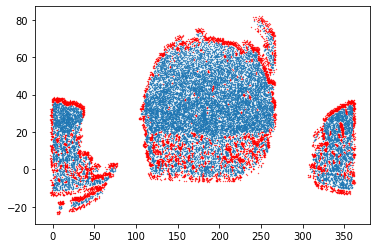

In [128]:
plt.scatter(ard_not_adv['amf_ra'],ard_not_adv['amf_dec'],s=0.1)
plt.scatter(ras_good,decs_good,s=0.1,color='red')
# plt.xlim(100,250)

In [129]:
len(ras_good)

9034

#### Planck

In [42]:
pl = hp.read_map("../data/HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits")
pl[pl<-1e23]=0

shape,wcs = enmap.fullsky_geometry(res=5.0 * utils.arcmin,proj='car')
map_pix = reproject.enmap_from_healpix(pl,shape=shape,wcs=wcs)

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


#### ROSAT

In [43]:
# ros = hp.read_map("../data/rass_healpix_countsec.fits")
# mask = hp.read_map("../data/mask_comprass.fits")

# ros[ros<-1e23]=0

# masked_ros = []
# for i in tqdm(range(len(mask))):
#     masked_ros.append(0)
#     if mask[i]:
#         masked_ros[i]=ros[i]

# masked_ros = np.array(masked_ros)

# shape,wcs = enmap.fullsky_geometry(res=5.0 * utils.arcmin,proj='car')
# map_pix = reproject.enmap_from_healpix(masked_ros,shape=shape,wcs=wcs)

#### ACT

In [44]:
# map_pix = enmap.read_map("../data/act_dr5.01_s08s18_AA_f220_daynight_map.fits")

---

# Intensity extraction

In [45]:
# Full
# ras = np.linspace(0,360,142)
# decs1 = np.linspace(-90,-25,71)
# decs2 = np.linspace(25,90,71)
# decs = np.concatenate((decs1,decs2))

# Fake
ras = np.loadtxt('fakeras.csv',delimiter=', ')
decs = np.loadtxt('fakedecs.csv',delimiter=', ')

# Real
# ras  = ard_not_adv['amf_ra']
# decs = ard_not_adv['amf_dec']

N = len(ras)
# N=10
stack_CMB_kSZ           = 0
stack_CMB_kSZ_deproject = 0
c = 0

In [46]:
# # signal = []

# # Fake/Real depending on ras/decs
# def cluster_data(i):
#     stamp = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[i]]),r=3*utils.arcmin)

#     if stamp is None or stamp[0][0][0]==0.0:
#         signal.append(0)
#     else:
#         signal.append(sum(sum(stamp[0]))/9)
        
#     return signal

# # Full map
# def full_map_data(i):
#     for j in range(N):
#         stamp = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[j]]),r=3*utils.arcmin)

#         if stamp is None:
#             continue
#         elif stamp[0][0][0]==0.0:
#             continue

#         signal.append(sum(sum(stamp[0]))/9)
        
#     return signal

# with mp.Pool(processes = 6) as p:
#     results = p.map(cluster_data, [x for x in range(100)])

In [47]:
signal = []

# Full map
# for j in tqdm(range(N)):
#     for i in range(N):
#         stamp = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[j], ras[i]]),r=3*utils.arcmin)

#         if stamp is None:
#             signal.append(0)
#             continue
#         elif stamp[0][0][0]==0.0:
#             signal.append(0)
#             continue

#         signal.append(sum(sum(stamp[0]))/9)
#         ras_temp.append(ras[i])
#         decs_temp.append(decs[j])

# Fake
for i in tqdm(range(N)):
    stamp = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[i]]),r=3*utils.arcmin)
    if stamp is None: signal.append(0)
    elif stamp[0][0][0]==0.0: signal.append(0)
    else: signal.append(sum(sum(stamp[0]))/9)
    
# Real
# for i in tqdm(range(N)):
#     stamp = reproject.thumbnails(map_pix,coords = np.deg2rad([decs[i], ras[i]]),r=3*utils.arcmin)

#     if stamp is None:
#         signal.append(0)
#         continue
#     elif stamp[0][0][0]==0.0:
#         signal.append(0)
#         continue

#     signal.append(sum(sum(stamp[0]))/9)

100%|██████████| 21006/21006 [02:28<00:00, 141.74it/s]


In [48]:
len(signal)

21006

In [130]:
# np.savetxt("fakeintensity143.csv",
#            signal,
#            delimiter=", ",
#            fmt='% s')

# np.savetxt("fakeras.csv",
#            ras_good,
#            delimiter=", ",
#            fmt='% s')

# np.savetxt("fakedecs.csv",
#            decs_good,
#            delimiter=", ",
#            fmt='% s')